In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys

sys.path.append("../")

import torch
import transformers
import baukit
from tqdm.auto import tqdm
import json
import os
from src import functional
import numpy as np
import logging
from src import models
from datasets import load_dataset

from src.utils import logging_utils, env_utils
logger = logging.getLogger(__name__)
logging.basicConfig(
    level=logging.DEBUG,
    format=logging_utils.DEFAULT_FORMAT,
    datefmt=logging_utils.DEFAULT_DATEFMT,
    stream=sys.stdout,
)

torch.__version__, transformers.__version__, torch.version.cuda

/home/local_arnab/miniconda3/envs/sae/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


('2.3.1', '4.43.3', '12.1')

In [3]:
# eval_dataset_name = "mickume/harry_potter_tiny"
eval_dataset_name = "jahjinx/IMDb_movie_reviews"
eval_data = load_dataset(eval_dataset_name)

2024-08-22 19:04:59 urllib3.connectionpool DEBUG    Starting new HTTPS connection (1): huggingface.co:443


2024-08-22 19:04:59 urllib3.connectionpool DEBUG    https://huggingface.co:443 "GET /api/datasets/jahjinx/IMDb_movie_reviews HTTP/11" 200 1692
2024-08-22 19:04:59 urllib3.connectionpool DEBUG    Starting new HTTPS connection (1): s3.amazonaws.com:443
2024-08-22 19:04:59 urllib3.connectionpool DEBUG    https://s3.amazonaws.com:443 "HEAD /datasets.huggingface.co/datasets/datasets/jahjinx/IMDb_movie_reviews/jahjinx/IMDb_movie_reviews.py HTTP/11" 404 0
2024-08-22 19:04:59 urllib3.connectionpool DEBUG    https://huggingface.co:443 "GET /api/datasets/jahjinx/IMDb_movie_reviews HTTP/11" 200 1692
2024-08-22 19:04:59 urllib3.connectionpool DEBUG    Starting new HTTPS connection (1): huggingface.co:443
2024-08-22 19:04:59 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /datasets/jahjinx/IMDb_movie_reviews/resolve/ef30f6a046230c843d79822b928267efd9453d5b/README.md HTTP/11" 200 0
2024-08-22 19:04:59 urllib3.connectionpool DEBUG    Starting new HTTPS connection (1): huggingface.co:

In [4]:
models = [
    "EleutherAI/pythia-160m",
    "EleutherAI/pythia-410m",
]
sae_datasets = [
    "rand_1", "rand_2"
]

cache_path_root = os.path.join(env_utils.DEFAULT_RESULTS_DIR, "sae_mixtures", eval_dataset_name.split("/")[-1] + "_rand")
# os.makedirs(cache_path_root, exist_ok=True)

In [5]:
limit = 8000

for model_name in models:
    for sae_data in sae_datasets:
        logger.info(f"model={model_name}, sae_data={sae_data}")
        cache_path = os.path.join(cache_path_root, model_name.split("/")[-1], sae_data.split("/")[-1])

        id_to_mixture = {}
        for sae_mixture_file in tqdm(os.listdir(cache_path)):
            data = np.load(os.path.join(cache_path, sae_mixture_file))
            # take the average of the reps as the feature #! Is this the best way to do it?
            sae_mixture = torch.Tensor(data["sae_mixture"]).squeeze().mean(dim=0)   
            id_to_mixture[int(sae_mixture_file.split(".")[0])] = sae_mixture
        
        all_states = []
        for doc_index in tqdm(range(len(eval_data["train"][:limit]["text"]))):
            all_states.append(id_to_mixture[doc_index])
        
        np.savez_compressed(
            os.path.join(cache_path_root, f"{model_name.split('/')[-1]}_{sae_data.split('/')[-1]}_states.npz"),
            all_states=all_states
        )

2024-08-22 19:05:00 __main__ INFO     model=EleutherAI/pythia-160m, sae_data=rand_1


  0%|          | 0/8000 [00:00<?, ?it/s]

100%|██████████| 8000/8000 [00:00<00:00, 3732002.22it/s]


2024-08-22 19:07:00 __main__ INFO     model=EleutherAI/pythia-160m, sae_data=rand_2


100%|██████████| 8000/8000 [00:00<00:00, 2826588.49it/s]


2024-08-22 19:09:00 __main__ INFO     model=EleutherAI/pythia-410m, sae_data=rand_1


100%|██████████| 8000/8000 [00:00<00:00, 3487986.69it/s]


2024-08-22 19:10:55 __main__ INFO     model=EleutherAI/pythia-410m, sae_data=rand_2


100%|██████████| 8000/8000 [00:00<00:00, 2750363.28it/s]


In [6]:
def load_cached_states(npz_path):
    npz = np.load(npz_path)
    states = torch.Tensor(npz["all_states"]).cuda()
    states = torch.nn.functional.normalize(states, p=2, dim=1) # normalize the rows

    return states

In [7]:
similarity_kernels = {}

for model_name in models:
    similarity_kernels[model_name] = {}
    for sae_data in sae_datasets:
        states = load_cached_states(os.path.join(cache_path_root, f"{model_name.split('/')[-1]}_{sae_data.split('/')[-1]}_states.npz"))
        similarity_kernels[model_name][sae_data] = states @ states.T

        logger.info(f"model={model_name}, sae_data={sae_data} | similarity_kernel.shape={similarity_kernels[model_name][sae_data].shape}")

2024-08-22 19:12:51 __main__ INFO     model=EleutherAI/pythia-160m, sae_data=rand_1 | similarity_kernel.shape=torch.Size([8000, 8000])
2024-08-22 19:12:51 __main__ INFO     model=EleutherAI/pythia-160m, sae_data=rand_2 | similarity_kernel.shape=torch.Size([8000, 8000])
2024-08-22 19:12:52 __main__ INFO     model=EleutherAI/pythia-410m, sae_data=rand_1 | similarity_kernel.shape=torch.Size([8000, 8000])
2024-08-22 19:12:52 __main__ INFO     model=EleutherAI/pythia-410m, sae_data=rand_2 | similarity_kernel.shape=torch.Size([8000, 8000])


2024-08-22 19:12:52 matplotlib DEBUG    matplotlib data path: /home/local_arnab/miniconda3/envs/sae/lib/python3.11/site-packages/matplotlib/mpl-data
2024-08-22 19:12:52 matplotlib DEBUG    CONFIGDIR=/home/local_arnab/.config/matplotlib
2024-08-22 19:12:52 matplotlib DEBUG    interactive is False
2024-08-22 19:12:52 matplotlib DEBUG    platform is linux
2024-08-22 19:12:52 matplotlib DEBUG    CACHEDIR=/home/local_arnab/.cache/matplotlib
2024-08-22 19:12:52 matplotlib.font_manager DEBUG    Using fontManager instance from /home/local_arnab/.cache/matplotlib/fontlist-v330.json


2024-08-22 19:12:52 matplotlib.pyplot DEBUG    Loaded backend module://matplotlib_inline.backend_inline version unknown.
2024-08-22 19:12:52 matplotlib.pyplot DEBUG    Loaded backend module://matplotlib_inline.backend_inline version unknown.
2024-08-22 19:12:52 matplotlib.font_manager DEBUG    findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
2024-08-22 19:12:52 matplotlib.font_manager DEBUG    findfont: score(FontEntry(fname='/home/local_arnab/miniconda3/envs/sae/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/cmmi10.ttf', name='cmmi10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2024-08-22 19:12:52 matplotlib.font_manager DEBUG    findfont: score(FontEntry(fname='/home/local_arnab/miniconda3/envs/sae/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizFourSymReg.ttf', name='STIXSizeFourSym', style='normal', variant='normal', weight=400, stretch='normal', size='scal

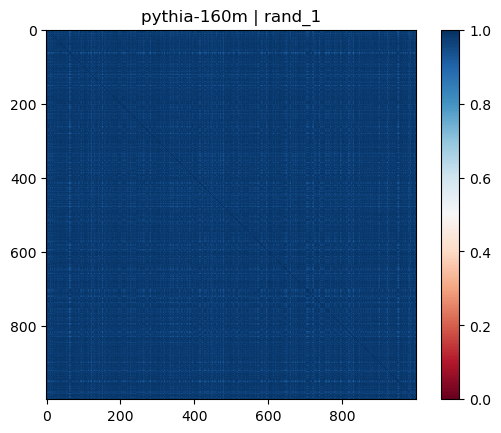

2024-08-22 19:12:53 matplotlib.colorbar DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x7f80111c0450>


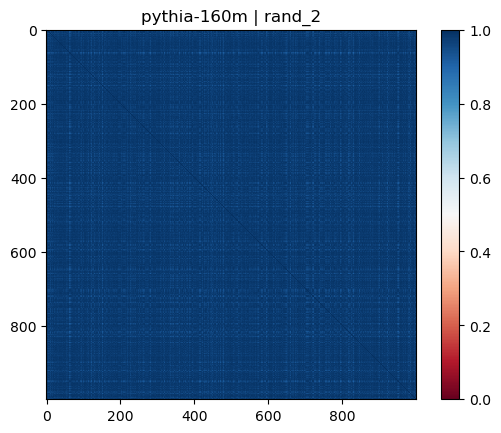

2024-08-22 19:12:53 matplotlib.colorbar DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x7f8011130310>


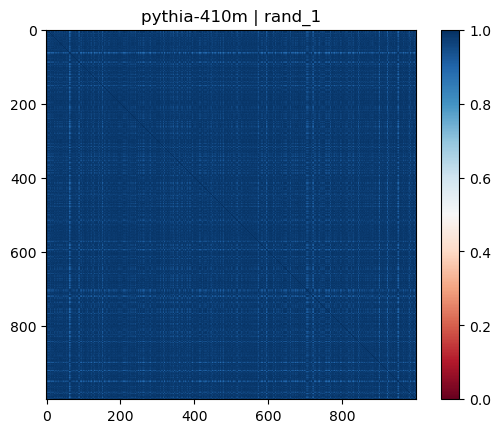

2024-08-22 19:12:53 matplotlib.colorbar DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x7f8011167b10>


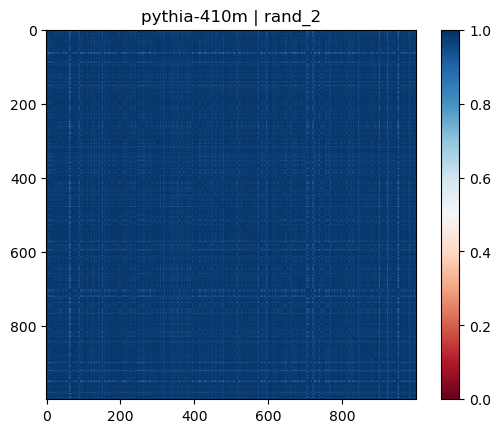

In [8]:
import matplotlib.pyplot as plt
from src.plotting import matrix_heatmap

for model_name in models:
    for sae_data in sae_datasets:
        matrix_heatmap(
            similarity_kernels[model_name][sae_data],
            title = f"{model_name.split('/')[-1]} | {sae_data.split('/')[-1]}",
            limit_dim = 1000,
        )


In [9]:
from src.metrics import AlignmentMetrics

edges = []
edges.append(((models[0], sae_datasets[0]), (models[0], sae_datasets[1])))
edges.append(((models[0], sae_datasets[0]), (models[1], sae_datasets[0])))
edges.append(((models[1], sae_datasets[1]), (models[1], sae_datasets[0])))
edges.append(((models[1], sae_datasets[1]), (models[0], sae_datasets[1])))


for node1, node2 in edges:
    model_name_1, sae_data_1 = node1
    model_name_2, sae_data_2 = node2

    F1 = load_cached_states(os.path.join(cache_path_root, f"{model_name_1.split('/')[-1]}_{sae_data_1.split('/')[-1]}_states.npz"))
    F2 = load_cached_states(os.path.join(cache_path_root, f"{model_name_2.split('/')[-1]}_{sae_data_2.split('/')[-1]}_states.npz"))

    mnn = AlignmentMetrics.mutual_knn(F1, F2, topk = 500)
    svcca = AlignmentMetrics.svcca(F1, F2, cca_dim=10)
    logger.info(f'({model_name_1.split("/")[-1]},{sae_data_1.split("/")[-1]}) vs ({model_name_2.split("/")[-1]},{sae_data_2.split("/")[-1]}) | {mnn=}, {svcca=}')

logger.info("-"*50)

cross = []
cross.append(((models[0], sae_datasets[0]), (models[1], sae_datasets[1])))
cross.append(((models[0], sae_datasets[1]), (models[1], sae_datasets[0])))

for node1, node2 in cross:
    model_name_1, sae_data_1 = node1
    model_name_2, sae_data_2 = node2

    F1 = load_cached_states(os.path.join(cache_path_root, f"{model_name_1.split('/')[-1]}_{sae_data_1.split('/')[-1]}_states.npz"))
    F2 = load_cached_states(os.path.join(cache_path_root, f"{model_name_2.split('/')[-1]}_{sae_data_2.split('/')[-1]}_states.npz"))

    mnn = AlignmentMetrics.mutual_knn(F1, F2, topk = 500)
    svcca = AlignmentMetrics.svcca(F1, F2, cca_dim=10)
    logger.info(f'({model_name_1.split("/")[-1]},{sae_data_1.split("/")[-1]}) vs ({model_name_2.split("/")[-1]},{sae_data_2.split("/")[-1]}) | {mnn=}, {svcca=}')

2024-08-22 19:12:55 __main__ INFO     (pythia-160m,rand_1) vs (pythia-160m,rand_2) | mnn=0.8967298269271851, svcca=0.9242778671865407


/home/local_arnab/miniconda3/envs/sae/lib/python3.11/site-packages/sklearn/cross_decomposition/_pls.py:113: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)


2024-08-22 19:12:56 __main__ INFO     (pythia-160m,rand_1) vs (pythia-410m,rand_1) | mnn=0.6165047883987427, svcca=0.7804145209522455
2024-08-22 19:12:57 __main__ INFO     (pythia-410m,rand_2) vs (pythia-410m,rand_1) | mnn=0.8905503153800964, svcca=0.882608784119444


/home/local_arnab/miniconda3/envs/sae/lib/python3.11/site-packages/sklearn/cross_decomposition/_pls.py:113: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)


2024-08-22 19:12:58 __main__ INFO     (pythia-410m,rand_2) vs (pythia-160m,rand_2) | mnn=0.6145393252372742, svcca=0.7644604425291317
2024-08-22 19:12:58 __main__ INFO     --------------------------------------------------
2024-08-22 19:12:59 __main__ INFO     (pythia-160m,rand_1) vs (pythia-410m,rand_2) | mnn=0.6155290007591248, svcca=0.7910869935341839
2024-08-22 19:13:00 __main__ INFO     (pythia-160m,rand_2) vs (pythia-410m,rand_1) | mnn=0.6150243282318115, svcca=0.7791411436377482
